# 합성곱 신경망 (Convolutional neural network)

## 합성곱/풀링 계층 구현하기
- CNN에 새롭게 등장하는 합성곱 계층과 풀링 계층
- CNN은 완전연결 계층과 달리 공간정보를 잃지않기 위해 4차원 입력데이터를 다룬다: (데이터 수, 입력 채널 수, 높이, 너비)
- for문을 이용한다면 합성곱 구현은 복잡해진다
- im2col() 이라는 함수를 이용하여 4차원의 데이터를 2차원으로 바꾸어 계산을 간단히 한다

### im2col() 함수
- https://github.com/WegraLee/deep-learning-from-scratch/blob/master/common/util.py#L39
- CNN의 순전파에 이용한다

In [1]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    # 입력데이터의 형태정보를 가져온다
    N, C, H, W = input_data.shape
    
    # 합성곱 결과의 형태를 계산한다 
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    # np.pad(패딩을 적용할 array, [각 axis에 패딩을 어떻게 적용할지 지정], '옵션')
    # 예) pad()의 리스트 인자의 세번째 튜플 (pad,pad)는 입력데이터 (H,W) 행렬의 위,아래로 행을 'pad'개 만큼 만든다
    # 예) pad()의 리스트 인자의 네번째 튜플 (pad,pad)는 입력데이터 (H,W) 행렬의 왼쪽,오른쪽으로 열을 'pad'개 만큼 만든다
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    
    # im2col()의 결과를 저장할 배열을 만든다
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    # 해당 필터 원소위치와 대응하는 데이터의 원소들을 묶어 col에 저장하는 것
    for y in range(filter_h):
        # y_max: 필터 원소와 대응하는 입력데이터의 원소들을 y 방향으로 stride씩 건너띄면서 가져올 때, 그 원소들을 모두 포함할 수 있는 범위 
        y_max = y + stride*out_h
        for x in range(filter_w):
            # x_max: 필터 원소와 대응하는 입력데이터의 원소들을 x 방향으로 stride씩 건너띄면서 가져올 때, 그 원소들을 모두 포함할 수 있는 범위
            x_max = x + stride*out_w
            
            # filter_xy와 곱할 입력데이터(img[:, :, y:y_max:stride, x:x_max:stride])를 col[:, :, y, x, :, :] 저장
            # y:y_max:stride에서 세번째 stride는 슬라이싱할때 건너뛰는 크기
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride] 

    # col을 이후에 2차원배열로 변환한 필터와 곱하기 위해 형상을 바꾸어준다 
    # col.transpose(0, 4, 5, 1, 2, 3) 결과는 (N, out_h, out_w, C, filter_h, filter_w)의 형태를 갖는 행렬
    # reshape후에는 (N*out_h*out_w, C*filter_h*filter_w)의 2차원 배열이다
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [2]:
# 아래 코드는 im2col()을 이용하여 (1,3,7,7)의 배열을 (9,75)의 형상을 갖는 배열로 바꾸어준다
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride = 1, pad = 0)
print(col1.shape)

(9, 75)


### col2im() 함수
- https://github.com/WegraLee/deep-learning-from-scratch/blob/master/common/util.py#L71
- CNN의 역전파에 이용한다

In [3]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0, useStrideMinusOne = False):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    
    # 전달된 col은 (N*out_h*out_w, C*filter_h*filter_w)의 2차원 배열
    # reshape() 후에는 (N, out_h, out_w, C, filter_h, filter_w)의 형상을 갖는 배열
    # transpose() 후에는 (N, C, filter_h, filter_w, out_h, out_w)의 형상을 갖는 배열
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    if useStrideMinusOne:
        # stride - 1은 불필요해 보인다 
        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    else :
        img = np.zeros((N, C, H + 2*pad, W + 2*pad))

    # 해당 필터 원소위치와 대응했던 입력 데이터의 원소들의 위치에 col에 저장되어 있는 값들을 더해준다
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [4]:
N = 1
C = 2
H = 5
W = 5

pad = 2
stride = 3
filter_h = 3
filter_w = 3

out_h = (H + 2*pad - filter_h)//stride + 1
out_w = (W + 2*pad - filter_w)//stride + 1

col = np.random.rand(N, out_h, out_w, C, filter_h, filter_w)
col = col.reshape(N*out_h*out_w, C*filter_h*filter_w)

In [5]:
test_input = np.random.rand(N, C, H, W)

- col2im()안의 img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))에서 stride-1의 필요 여부 확인
- 아래의 경우엔 stride-1 적용 유무와 관계없이 계산 결과가 같다

In [6]:
col2im(col, test_input.shape, filter_h, filter_w, stride, pad, True)

array([[[[0.87168911, 0.7704003 , 0.40590058, 0.18572948, 0.66011863],
         [0.57002312, 0.91296757, 0.36591159, 0.29046185, 0.67601474],
         [0.02304429, 0.277884  , 0.7476927 , 0.45057043, 0.19362876],
         [0.36087786, 0.98754318, 0.48628752, 0.79403852, 0.38870644],
         [0.80589617, 0.3195596 , 0.50356414, 0.22880794, 0.30957529]],

        [[0.21062932, 0.44295122, 0.86776278, 0.10535402, 0.92983448],
         [0.88623429, 0.78643518, 0.31788091, 0.83436125, 0.20156697],
         [0.14139289, 0.64126476, 0.02568289, 0.55636315, 0.97172398],
         [0.43002496, 0.36305871, 0.74597177, 0.3332126 , 0.92413881],
         [0.59991495, 0.95466626, 0.58599552, 0.78614593, 0.67975866]]]])

In [7]:
col2im(col, test_input.shape, filter_h, filter_w, stride, pad, False)

array([[[[0.87168911, 0.7704003 , 0.40590058, 0.18572948, 0.66011863],
         [0.57002312, 0.91296757, 0.36591159, 0.29046185, 0.67601474],
         [0.02304429, 0.277884  , 0.7476927 , 0.45057043, 0.19362876],
         [0.36087786, 0.98754318, 0.48628752, 0.79403852, 0.38870644],
         [0.80589617, 0.3195596 , 0.50356414, 0.22880794, 0.30957529]],

        [[0.21062932, 0.44295122, 0.86776278, 0.10535402, 0.92983448],
         [0.88623429, 0.78643518, 0.31788091, 0.83436125, 0.20156697],
         [0.14139289, 0.64126476, 0.02568289, 0.55636315, 0.97172398],
         [0.43002496, 0.36305871, 0.74597177, 0.3332126 , 0.92413881],
         [0.59991495, 0.95466626, 0.58599552, 0.78614593, 0.67975866]]]])

### 합성곱 계층 클래스
- https://github.com/WegraLee/deep-learning-from-scratch/blob/master/common/layers.py#L198
- 합성곱 연산은 필터의 윈도우를 일정 간격으로 이동해가며 입력과 필터의 대응하는 원소끼리 곱한 후 그 총합을 구한다

In [8]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape # N은 실질적으로 배치 사이즈
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        # col의 shape: (N*out_h*out_w, C*filter_h*filter_w)
        col = im2col(x, FH, FW, self.stride, self.pad)
        
        # im2col()의 결과로 나온 행렬과 dot()연산하기위해 변형한다
        # (C*filter_h*filter_w, FN)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        # 기본적으로 Affine 계층의 backward와 같다
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

### 풀링 계층 클래스
- https://github.com/WegraLee/deep-learning-from-scratch/blob/master/common/layers.py#L246

In [9]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad # Pooling 계층에서 실질적으로 pad는 필요없다
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        
        N, C, H, W = x.shape # 여기서 C는 입력데이터의 채널 수가 아니라 필터의 수, H(W)는 합성곱 결과의 높이(너비)
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride) # col.shape: (N*out_h*out_w, C*pool_h*pool_w)
        col = col.reshape(-1, self.pool_h*self.pool_w)         # col.shape: (N*out_h*out_w*C, pool_h*pool_w)

        arg_max = np.argmax(col, axis=1) # 최대값 인덱스의 배열
        out = np.max(col, axis=1)        # 최대값의 배열
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2) #out.shape: (N, C, out_h, out_w)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        # 최대값이 나온곳은 dout 값으로 그 외에는 0으로 채운다
        
        dout = dout.transpose(0, 2, 3, 1) # (N, out_h, out_w, C)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size)) # (N*out_h*out_w*C, pool_h*pool_w)
        # 최대값을 갖는 인덱스에 dout값을 넣어준다
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten() # self.arg_max.flatten() flatten()이 필요한가?
        dmax = dmax.reshape(dout.shape + (pool_size,)) # (N, out_h, out_w, C, pool_size)
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        # 입력이미지에 해당 하는 위치로 값을 넣어준다
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride)
        
        return dx

## CNN 구현하기

In [10]:
# 아래에서 구현할 SimpleConvNet에 필요한 클래스들을 옮겨놓았다

from collections import OrderedDict

# Relu 계층
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

# Affine 계층
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

#
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

#
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 
#
class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]
#
class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]

#
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
#
class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
#
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

#
class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        #if self.verbose: print("train loss:" + str(loss))
        
        # 에폭마다 정확도 확인 
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

#            
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

#
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


### SimpleConvNet class
- https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch07/simple_convnet.py#L11

In [11]:
class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    """
    
    # 가정들
    # CNN filter의 높이와 너비가 같다 
    # pooling filter의 높이:2 너비:2 스트라이드:2
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        
        filter_num    = conv_param['filter_num']
        filter_size   = conv_param['filter_size']
        filter_pad    = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size    = input_dim[1]
        
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        # 풀링 필터의 높이:2 너비:2 스트라이드: 2 인 경우에만 아래식이 성립한다
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

## CNN  학습해보기

In [12]:
import matplotlib.pyplot as plt
from mnist import load_mnist

max_epochs = 20

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# filter_num   : 필터 갯수 
# filter_size  : 필터 크기 (정방 행렬)

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 위에서 정의한 network를 흐르는 입력데이터의 형상 : (100, 1, 28, 28)
# 합성곱 필터 : (30, 1, 5, 5), stride: 1
# 풀링 필터 : (2, 2) stride: 2 (SimpleConvNet 안에서 정해져 있다)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)

In [13]:
%time trainer.train()

=== epoch:1, train acc:0.246, test acc:0.243 ===
=== epoch:2, train acc:0.961, test acc:0.96 ===
=== epoch:3, train acc:0.975, test acc:0.969 ===
=== epoch:4, train acc:0.979, test acc:0.976 ===
=== epoch:5, train acc:0.981, test acc:0.985 ===
=== epoch:6, train acc:0.986, test acc:0.98 ===
=== epoch:7, train acc:0.986, test acc:0.985 ===
=== epoch:8, train acc:0.992, test acc:0.99 ===
=== epoch:9, train acc:0.992, test acc:0.99 ===
=== epoch:10, train acc:0.994, test acc:0.986 ===
=== epoch:11, train acc:0.995, test acc:0.986 ===
=== epoch:12, train acc:0.994, test acc:0.987 ===
=== epoch:13, train acc:0.994, test acc:0.981 ===
=== epoch:14, train acc:0.996, test acc:0.986 ===
=== epoch:15, train acc:0.997, test acc:0.986 ===
=== epoch:16, train acc:0.997, test acc:0.988 ===
=== epoch:17, train acc:0.998, test acc:0.984 ===
=== epoch:18, train acc:1.0, test acc:0.987 ===
=== epoch:19, train acc:0.998, test acc:0.988 ===
=== epoch:20, train acc:0.999, test acc:0.983 ===
===============

In [14]:
import pickle

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

Saved Network Parameters!


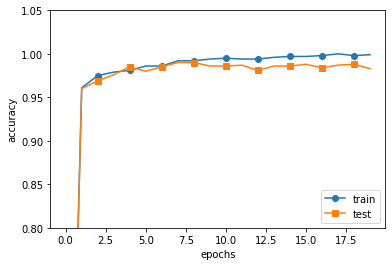

In [15]:
# 그래프 그리기

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0.8, 1.05)
plt.legend(loc='lower right')
plt.show()

### CNN 시각화하기
- 학습전과 학습후 필터의 이미지를 확인해본다

In [16]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


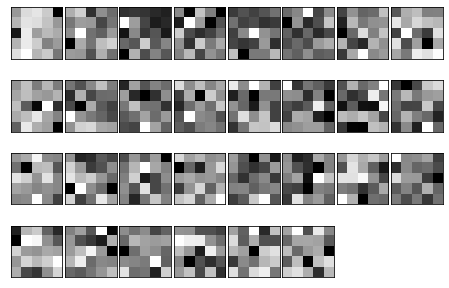

In [17]:
# 학습전 가중치
network = SimpleConvNet()
filter_show(network.params['W1'])

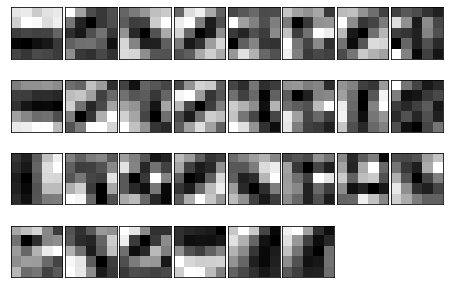

In [18]:
# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])